In [ ]:
#data manipulation
from pathlib import Path
import numpy as np
from numpy import percentile
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import glob
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


from math import sqrt
import scipy.stats

#double iteration in pandas
from itertools import product

#compute distance between two points on earth in spherical coordinates
from haversine import haversine, haversine_vector, Unit

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
import matplotlib.patches as patches
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
import seaborn as seabornInstance 
import seaborn as sns; sns.set(color_codes=True)

%matplotlib inline

In [26]:
# example for the SARAL-AltiKa editing criteria implementation
def remove_outliers(fname):
    
    #read the data files
    df2 = xr.open_dataset(fname)
    
    #select all the required variables to detect only the valid data
    df2 = df2[['swh','swh_rms','surface_type','wind_speed_alt','ice_flag','sig0','off_nadir_angle_wf','sig0_rms','range_rms','swh_numval', \
           'swh_rms']]
    
    # convert to pandas dataframe
    df2 = df2.to_dataframe()
    df2.reset_index(inplace=True)
    
        # apply the filtering criteria
    df2 = df2[(df2['surface_type'] == 0.) & (df2['ice_flag'] == 0.) & (df2['swh'] < 30.) & (df2['sig0'] < 30.) & (df2['sig0'] > 3.) \
            & (df2['off_nadir_angle_wf'] < 0.0625) & (df2['off_nadir_angle_wf'] > -0.2) & (df2['wind_speed_alt'] < 30) & \
             (df2['sig0_rms'] < 1) & (df2['range_rms'] < 0.2) & (df2['swh_numval'] > 20) & (df2['swh_rms'] < df2['swh'])]
    
    outliers_removed = df2

    return outliers_removed

In [27]:
# Directory of Saral-AltiKa data (not included here)
p = Path('C:/Users/panmits86/Desktop/Python/data/SARAL-AltiKa/IGDR')

# iterate the process to every data file
results = []
for fname in p.glob('*.nc'):
    swh_sa = remove_outliers(fname)
    results.append(swh_sa)
    swh = pd.concat(results, sort=True)

In [42]:
#creates a table of all SARAL-Altika Hs and wind speed data
swh_sa = swh[['time','lon','lat','swh','wind_speed_alt']]
swh_sa = swh_sa.reset_index()
swh_sa.drop(['index'], axis=1, inplace=True)
swh_sa

,time,lon,lat,swh,wind_speed_alt
0,2014-08-21 23:28:09.197778944,286.287362,40.555752,0.652,4.24
1,2014-08-21 23:28:11.270705920,286.247050,40.434171,0.829,5.36
2,2014-08-21 23:28:13.343635072,286.206852,40.312579,0.775,5.10
3,2014-08-21 23:28:14.380099072,286.186796,40.251778,0.814,5.07
4,2014-08-21 23:28:15.416562112,286.166767,40.190975,0.816,4.96
...,...,...,...,...,...
8484,2019-12-22 10:22:46.047041920,286.145365,40.025461,0.576,4.69
8485,2019-12-22 10:22:47.084560896,286.125404,40.086325,0.296,4.74
8486,2019-12-22 10:22:48.122082176,286.105414,40.147186,0.407,4.58
8487,2019-12-22 10:22:49.159601152,286.085398,40.208044,0.489,4.26


In [29]:
# save valid AltiKa data to a file (it is included in the repository)
swh_sa.to_csv(r"swh_sa.csv",sep='\t',index=False)

In [40]:
# read the file and load AltiKa data (start here if using binder)
swh_sa = pd.read_csv("swh_sa.csv", sep='\t')
swh_sa.head()

,time,lon,lat,swh,wind_speed_alt
0,2014-08-21 23:28:09.197778944,286.287362,40.555752,0.652,4.24
1,2014-08-21 23:28:11.270705920,286.247050,40.434171,0.829,5.36
2,2014-08-21 23:28:13.343635072,286.206852,40.312579,0.775,5.10
3,2014-08-21 23:28:14.380099072,286.186796,40.251778,0.814,5.07
4,2014-08-21 23:28:15.416562112,286.166767,40.190975,0.816,4.96


In [34]:
#.xlsx file directory of buoy locations (longitude, latitude)
#Alternatively, you can set the variable b44017=(latitude, longitude+360)

buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="D:E")
b44017 = (buoys['Latitude'][3],buoys['Longitude'][3]+360)
b44017

(40.693, 287.951)

In [35]:
def parse(yr, mo, doy, hr, min):
    yr, mo, doy, hr, min = [int(x) for x in [yr, mo, doy, hr, min]]
    dt = datetime(yr - 0, mo, doy, hr, min)
    return dt

In [36]:
#directory to buoy 44017 files

path = r'44017/'
all_files = glob.glob(path + "/*.txt")

b44017_wind_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44017_wind_wave = b44017_wind_wave[(b44017_wind_wave.WVHT !=99) & (b44017_wind_wave.WVHT > 0.0) &
                                   (b44017_wind_wave.WSPD !=99) & (b44017_wind_wave.WSPD > 0.0)]
b44017_wind_wave.reset_index(inplace=True)
b44017_wind_wave.drop('index', 1, inplace=True)
#b44017_wind_wave['u10'] = b44017_wind_wave['WSPD']*(10/4.1)**0.11
b44017_wind_wave['u10'] = b44017_wind_wave['WSPD']*np.sqrt((0.4**2)/0.0014)*(1/(np.log(4.1/0.000097)))
b44017_wind_wave.head()

,Date,WSPD,WVHT,u10
0,2013-12-31 23:50:00,13.6,1.81,13.649364
1,2014-01-01 00:50:00,13.0,1.94,13.047187
2,2014-01-01 01:50:00,11.7,1.96,11.742468
3,2014-01-01 02:50:00,11.0,1.97,11.039927
4,2014-01-01 03:50:00,11.5,1.86,11.541742
...,...,...,...,...
31346,2019-08-23 06:40:00,3.9,1.37,3.914156
31347,2019-08-23 07:40:00,4.0,1.36,4.014519
31348,2019-08-23 08:40:00,4.6,1.38,4.616697
31349,2019-08-23 09:40:00,3.5,1.31,3.512704


In [44]:
b44017_time = b44017_wind_wave['Date']
a1 = [(swh_sa['lat'][n], swh_sa['lon'][n]) for n in range(swh_sa.shape[0])]
# compute the distance between each SARAL-AltiKa and the position of buoy 44097
hav5 = haversine_vector([b44017]*swh_sa.shape[0],a1, Unit.KILOMETERS)
coloc = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])
coloc

,Buoy-Sat. Distance (km)
0,141.229915
1,146.784680
2,153.411456
3,157.085329
4,160.978039
...,...
8484,170.043246
8485,168.685121
8486,167.606105
8487,166.811354


In [45]:
swh_sa['Buoy-Sat. Distance (km)'] = coloc
#Removes data that is not within 0.25 decimal degrees of buoy 44017's location
swh_sa= swh_sa[((swh_sa[['lon','lat']] - [287.951,40.693])**2).sum(axis=1) < 0.25**2]
swh_sa

,time,lon,lat,swh,wind_speed_alt,Buoy-Sat. Distance (km)
89,2014-09-14 10:21:57.582557888,288.121075,40.599083,1.530,9.360000,17.746944
121,2014-09-22 23:22:17.267220992,287.823030,40.859468,1.941,8.250000,21.418436
122,2014-09-22 23:22:18.304742080,287.802701,40.798645,1.987,9.200000,17.148607
187,2014-10-19 10:21:56.373651968,288.102815,40.639992,1.857,9.010000,14.096051
188,2014-10-19 10:21:58.447635904,288.062288,40.761600,1.914,9.679999,12.088409
...,...,...,...,...,...,...
8115,2019-08-16 10:15:35.283711872,287.914875,40.627817,1.156,5.110000,7.862519
8116,2019-08-16 10:15:36.321230848,287.894626,40.688652,1.166,5.140000,4.777554
8117,2019-08-16 10:15:37.358751744,287.874349,40.749484,1.091,4.780000,9.009727
8118,2019-08-16 10:15:38.396273152,287.854043,40.810313,1.114,4.460000,15.390438


In [46]:
swh_sa.reset_index(inplace=True)
swh_sa.drop('index', 1, inplace=True)
colocated=swh_sa
colocated

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,time,lon,lat,swh,wind_speed_alt,Buoy-Sat. Distance (km)
0,2014-09-14 10:21:57.582557888,288.121075,40.599083,1.530,9.360000,17.746944
1,2014-09-22 23:22:17.267220992,287.823030,40.859468,1.941,8.250000,21.418436
2,2014-09-22 23:22:18.304742080,287.802701,40.798645,1.987,9.200000,17.148607
3,2014-10-19 10:21:56.373651968,288.102815,40.639992,1.857,9.010000,14.096051
4,2014-10-19 10:21:58.447635904,288.062288,40.761600,1.914,9.679999,12.088409
...,...,...,...,...,...,...
398,2019-08-16 10:15:35.283711872,287.914875,40.627817,1.156,5.110000,7.862519
399,2019-08-16 10:15:36.321230848,287.894626,40.688652,1.166,5.140000,4.777554
400,2019-08-16 10:15:37.358751744,287.874349,40.749484,1.091,4.780000,9.009727
401,2019-08-16 10:15:38.396273152,287.854043,40.810313,1.114,4.460000,15.390438


In [47]:
sat_time = colocated['time'].reset_index()
sat_time.drop('index', 1, inplace=True)

In [48]:
#time difference in minutes
diff = [(b44017_time[d], b44017_wind_wave['WVHT'][d], b44017_wind_wave['u10'][d], sat_time['time'][s], colocated['swh'][s], \
         colocated['wind_speed_alt'][s], colocated['Buoy-Sat. Distance (km)'][s], (sat_time['time'][s] - b44017_time[d]).total_seconds() / 60) \
        for d, s in product(range(b44017_time.shape[0]), range(sat_time.shape[0]))]
t = pd.DataFrame(list(diff))
t.columns = ['Buoy 44017 Time', 'Buoy 44017 Wave Height', 'Buoy 44017 U10', 'SARAL-AltiKa Time', 'SARAL-AltiKa Wave Height', \
             'SARAL-AltiKa Wind Speed', 'Buoy-Sat. Distance (km)', 'Time Difference (min.)']
final = abs(t['Time Difference (min.)']) < 30.
final1 = t[final]
final1 = final1.set_index('Buoy 44017 Time')
final1

,Buoy 44017 Wave Height,Buoy 44017 U10,SARAL-AltiKa Time,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed,Buoy-Sat. Distance (km),Time Difference (min.)
Buoy 44017 Time,,,,,,,
2015-05-17 10:50:00,1.13,1.806534,2015-05-17 10:21:24.779890048,1.243,4.01,20.375477,-28.587002
2015-05-17 10:50:00,1.13,1.806534,2015-05-17 10:21:25.816355968,1.182,3.67,16.774255,-28.569727
2015-05-17 10:50:00,1.13,1.806534,2015-05-17 10:21:28.925748096,1.354,3.52,21.524766,-28.517904
2015-05-25 23:50:00,0.78,9.133031,2015-05-25 23:21:34.382832064,0.975,7.29,15.264245,-28.426953
2015-05-25 23:50:00,0.78,9.133031,2015-05-25 23:21:37.495393024,0.982,7.59,10.457612,-28.375077
...,...,...,...,...,...,...,...
2019-08-16 10:40:00,1.17,4.817423,2019-08-16 10:15:35.283711872,1.156,5.11,7.862519,-24.411938
2019-08-16 10:40:00,1.17,4.817423,2019-08-16 10:15:36.321230848,1.166,5.14,4.777554,-24.394646
2019-08-16 10:40:00,1.17,4.817423,2019-08-16 10:15:37.358751744,1.091,4.78,9.009727,-24.377354


In [49]:
final1.index = pd.to_datetime(final1.index)

In [50]:
#results for buoy-satellite corresponding data within 0.25 radius. 
#Repeat the process for data within 0.5 radius to conduct the weibull_fit
df = final1.iloc[:,[0,1,3,4]]
df = df.resample('D').mean()
df = df.dropna()
df
df.to_csv('44017_df_25.csv')

In [82]:
# load the collocated buoy/AltiKa data
df = pd.read_csv("44017_df_25.csv")
df.head()

,Buoy 44017 Time,Buoy 44017 Wave Height,Buoy 44017 U10,SARAL-AltiKa Wave Height,SARAL-AltiKa Wind Speed
0,2015-05-17,1.13,1.806534,1.259667,3.733333
1,2015-05-25,0.78,9.133031,1.025750,7.730000
2,2015-06-29,1.58,7.527223,1.620857,6.157143
3,2015-07-26,0.62,4.717060,0.651600,4.506000
4,2015-08-03,1.39,8.731579,1.241600,6.810000


In [51]:
#calculated bias
df['SWH Difference'] = df['SARAL-AltiKa Wave Height'] - df['Buoy 44017 Wave Height']
bias = df["SWH Difference"].sum() / len(df)
bias

0.042049285682243476

In [52]:
df['wind Difference'] = df['SARAL-AltiKa Wind Speed'] - df['Buoy 44017 U10']
bias = df["wind Difference"].sum() / len(df)
bias

-0.36725665985214334

In [53]:
x = df['Buoy 44017 U10']
y = df['Buoy 44017 Wave Height']

xx = df['SARAL-AltiKa Wind Speed']
yy = df['SARAL-AltiKa Wave Height']

In [54]:
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], xx)

x1fit = np.linspace(0, 17, 61)
y1fit = model.predict(x1fit[:, np.newaxis])

print("Model slope:", model.coef_[0])

Model slope: 0.8847647034743014


In [55]:
scores_mean = list()
scores_std = list()

C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


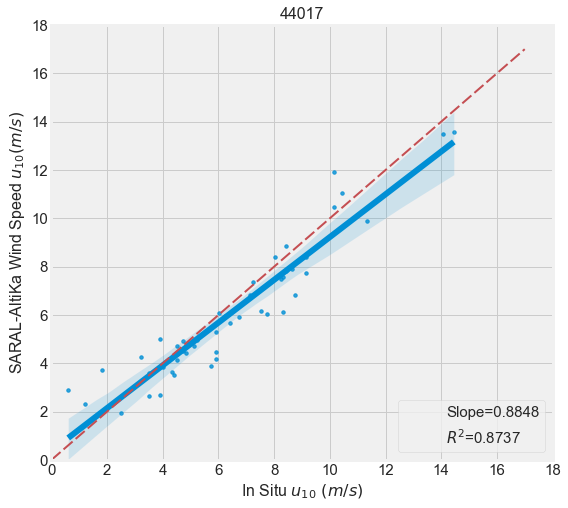

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(x,xx, scatter_kws={'s':12},ci=99)
plt.plot([0, 17], [0, 17], dashes=[6, 2], linewidth=2, color='r')

plt.xlabel('In Situ $u_{10} \ (m/s)$', fontsize=16)
plt.ylabel('SARAL-AltiKa Wind Speed $u_{10} (m/s)$', fontsize=16)
plt.title('44017', size=16)
plt.plot([], [], ' ', label="Slope=0.8848")
plt.plot([], [], ' ', label="$R^2$=0.8737")

plt.ylim(0,18)
plt.xlim(0,18)

plt.legend(prop={'size': 15},loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=15)

In [58]:
sqrt(mean_squared_error(df['Buoy 44017 U10'], df['SARAL-AltiKa Wind Speed']))

1.046968603563318

In [59]:
r2_score(df['Buoy 44017 U10'], df['SARAL-AltiKa Wind Speed'])

0.8736729058138026

In [60]:
scipy.stats.pearsonr(df['Buoy 44017 U10'], df['SARAL-AltiKa Wind Speed'])

(0.9429950324771411, 1.2984121934964631e-23)

In [61]:
scipy.stats.spearmanr(df['Buoy 44017 U10'], df['SARAL-AltiKa Wind Speed'])

SpearmanrResult(correlation=0.9450222052617565, pvalue=5.771055499998832e-24)

In [62]:
model = LinearRegression(fit_intercept=True)

model.fit(y[:, np.newaxis], yy)

x2fit = np.linspace(0, 4, 1000)
y2fit = model.predict(x2fit[:, np.newaxis])

print("Model slope:", model.coef_)

Model slope: [0.88176018]


C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 4.2)

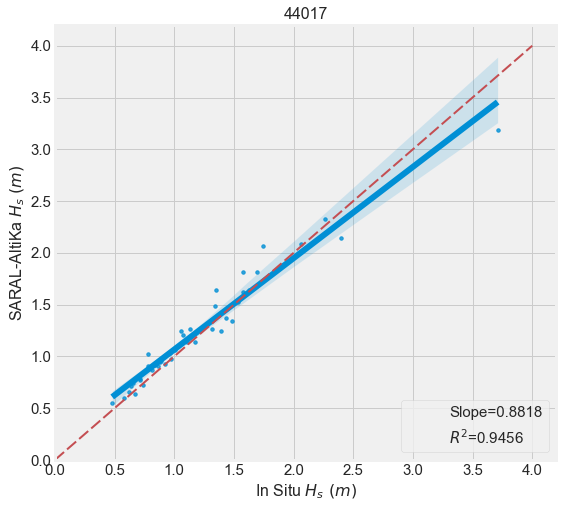

In [63]:
scores_mean = list()
scores_std = list()
fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(y,yy, scatter_kws={'s':12},ci=99)
plt.plot([0, 4], [0, 4], dashes=[6, 2], linewidth=2, color='r')

plt.xlabel('In Situ $H_{s} \ (m)$', fontsize=16)
plt.ylabel('SARAL-AltiKa $H_{s} \ (m)$', fontsize=16)
plt.title('44017', size=16)
plt.plot([], [], ' ', label="Slope=0.8818")
plt.plot([], [], ' ', label="$R^2$=0.9456")
plt.legend(prop={'size': 15},loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,4.2)
plt.xlim(0,4.2)

In [64]:
sqrt(mean_squared_error(df['Buoy 44017 Wave Height'], df['SARAL-AltiKa Wave Height']))

0.13829217056588106

In [65]:
r2_score(df['Buoy 44017 Wave Height'], df['SARAL-AltiKa Wave Height'])

0.9455511368510726

In [66]:
scipy.stats.pearsonr(df['Buoy 44017 Wave Height'], df['SARAL-AltiKa Wave Height'])

(0.9779631810219518, 6.066114127313404e-33)

In [67]:
scipy.stats.spearmanr(df['Buoy 44017 Wave Height'], df['SARAL-AltiKa Wave Height'])

SpearmanrResult(correlation=0.9805124365676997, pvalue=3.6871693826616467e-34)

In [68]:
model1 = LinearRegression(fit_intercept=False)


xfit = np.linspace(pd.Series.min(x), pd.Series.max(x), 1000)

poly_model = make_pipeline(PolynomialFeatures(2), model1)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])
poly_model.steps[1][1].coef_

array([ 0.97169843, -0.09028784,  0.01626612])

Text(0.5, 1.0, 'Buoy 44017- 0.25 decimal degrees Satellite Wind Speed-$H_{s}$ comparison')

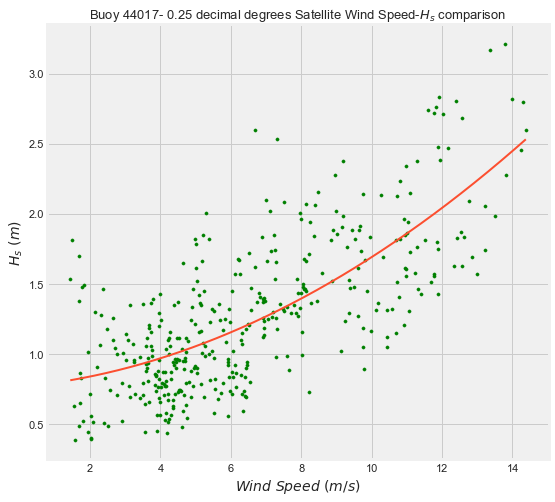

In [70]:
df3=pd.read_csv("swh_sa.csv", sep='\t')

colocated7= df3[((df3[['lon','lat']] - [287.951,40.693])**2).sum(axis=1) < 0.25**2]
yy=colocated7['swh']
xx=colocated7['wind_speed_alt']

model2 = LinearRegression(fit_intercept=False)

xxfit = np.linspace(pd.Series.min(xx), pd.Series.max(xx), 1000)

poly_model1 = make_pipeline(PolynomialFeatures(2), model2)

poly_model1.fit(xx[:, np.newaxis], yy)
yyfit = poly_model1.predict(xxfit[:, np.newaxis])

scores_mean = list()
scores_std = list()
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(xx, yy, s=10, color='green', label='SARAL-AltiKa data')
ax.plot(xxfit, yyfit, linewidth=2, label="SARAL-AltiKa", color='#fc4f30')

plt.xlabel('$Wind \ Speed \ (m/s)$', fontsize=14)
plt.ylabel('$H_{s} \ (m)$', fontsize=14)
plt.title('Buoy 44017- 0.25 decimal degrees Satellite Wind Speed-$H_{s}$ comparison', size=13)

In [71]:
poly_model1.steps[1][1].coef_

array([0.76255395, 0.02371192, 0.00690233])

In [72]:
sqrt(mean_squared_error(colocated7['wind_speed_alt'], colocated7['swh']))

5.893613288392381

In [73]:
scipy.stats.pearsonr(colocated7['wind_speed_alt'], colocated7['swh'])

(0.7190228138972508, 2.370661714518603e-65)

In [74]:
scipy.stats.spearmanr(colocated7['wind_speed_alt'], colocated7['swh'])

SpearmanrResult(correlation=0.6882711760013897, pvalue=7.338230831015781e-58)

Model slope: 0.09617012969024717
Model slope: 0.09952879610178869


<ipython-input-75-311daba76d48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colocated7['nlog SARAL-AltiKa Wave Height']=np.log(colocated7['swh'])


Text(0.5, 1.0, '44017')

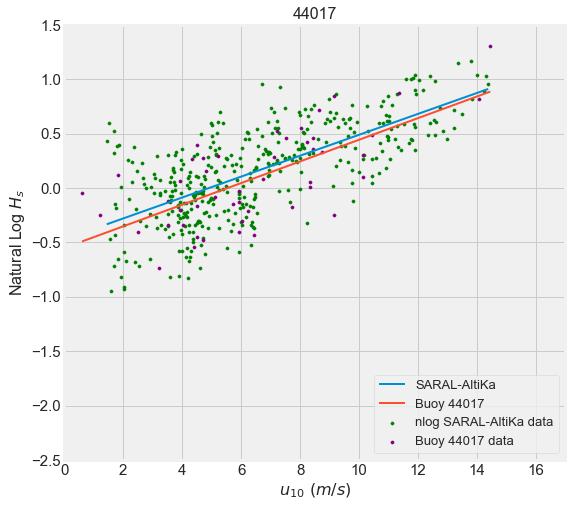

In [75]:
df4=pd.read_csv("swh_sa.csv", sep='\t')
colocated7= df4[((df4[['lon','lat']] - [287.951,40.693])**2).sum(axis=1) < 0.25**2]
colocated7['nlog SARAL-AltiKa Wave Height']=np.log(colocated7['swh'])
xx=colocated7['wind_speed_alt']
yy=colocated7['nlog SARAL-AltiKa Wave Height']

model = LinearRegression(fit_intercept=True)

model.fit(xx[:, np.newaxis], yy)

x1fit = np.linspace(pd.Series.min(xx), pd.Series.max(xx), 1000)
y1fit = model.predict(x1fit[:, np.newaxis])
print("Model slope:", model.coef_[0])

scores_mean = list()
scores_std = list()
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(xx, yy, s=10, color='green', label='nlog SARAL-AltiKa data')
plt.plot(x1fit, y1fit, linewidth=2, label='SARAL-AltiKa')


df['natural_log_buoy_Hs']=np.log(df['Buoy 44017 Wave Height'])
y=df['natural_log_buoy_Hs']
x = df['Buoy 44017 U10']
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(pd.Series.min(x), pd.Series.max(x), 1000)
yfit = model.predict(xfit[:, np.newaxis])
print("Model slope:", model.coef_[0])

ax.scatter(x, y, s=10,color='purple', label='Buoy 44017 data')
ax.plot(xfit, yfit, linewidth=2, label='Buoy 44017')




plt.ylim(-2.5,1.5)
plt.xlim(0,17)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(prop={'size': 13}, loc="lower right")
plt.xlabel('$u_{10} \ (m/s)$', fontsize=16)
plt.ylabel('Natural Log $H_{s}$', fontsize=16)
plt.title('44017', size=16)

In [76]:
scipy.stats.pearsonr(colocated7['wind_speed_alt'], colocated7['nlog SARAL-AltiKa Wave Height'])

(0.6964723371953704, 9.139895633175837e-60)

In [77]:
scipy.stats.pearsonr(df['natural_log_buoy_Hs'],df['Buoy 44017 U10'])

(0.6888178216466487, 6.227565060185555e-08)

In [78]:
sqrt(mean_squared_error(df['natural_log_buoy_Hs'],df['Buoy 44017 U10']))

6.895197303771772

In [79]:
sqrt(mean_squared_error(colocated7['wind_speed_alt'], colocated7['nlog SARAL-AltiKa Wave Height']))

6.939780304900387

In [80]:
model = LinearRegression(fit_intercept=True)

model.fit(xx[:, np.newaxis], yy)
print("Model slope:", model.coef_[0])

Model slope: 0.09617012969024717
